## Importação das bibliotecas

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyart
import warnings
import math
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Leitura dos dados

In [3]:
xds = xr.open_dataset('data/sbmn_cappi_20140103_031208.nc')

### Descrição das variáveis

In [4]:
xds.data_vars

Data variables:
    start_time      (time) datetime64[ns] ...
    stop_time       (time) datetime64[ns] ...
    time_bounds     (time, bounds) datetime64[ns] ...
    grid_mapping_0  int32 ...
    VEL             (time, z0, y0, x0) float32 ...
    DBZc            (time, z0, y0, x0) float32 ...
    range           (time, z0, y0, x0) float32 ...
    Coverage        (time, z0, y0, x0) float32 ...

#### Unidade das variáveis

In [5]:
dbz_unit = xds.DBZc.units
x0_unit = xds.x0.units
y0_unit = xds.y0.units

print('Unidade DBCc:   '+dbz_unit+ '\nUnidade de X0:  ' + x0_unit + '\nUnidade de Y0:  ' + y0_unit)

Unidade DBCc:   dBZ
Unidade de X0:  km
Unidade de Y0:  km


#### Agregação dos valores

In [6]:
dbz = xds.DBZc.data
lat = xds.DBZc['lat0'].data
lon = xds.DBZc['lon0'].data
x0 = xds.DBZc['x0'].data
y0 = xds.DBZc['y0'].data
rrange = xds.range.data
rrange = rrange[0]

### Calculo do MAXCAPPI

In [7]:
def maxCAPPI(data):
    
    maxC = np.zeros(241*241)-9999
    maxC = np.reshape(maxC,(241,241))
    
    #### Percorrendo matrix 40x
    for k in range(len(data[0])):
        ### Percorre Linhas
        for i in range(len(data[0][k])):
            ### Percorre Colunas
            for j in range(len(data[0][k])):
                #verifica se é diferente de nan
                if math.isnan(data[0][k][i][j]) != True:
                    ### Verifica se i e j são maiores que o anterior
                    if data[0][k][i][j] > maxC[i][j]:
                        maxC[i][j] = data[0][k][i][j]
    
    ## Altera valor -9999 para nan
    for i in range(241):
        for j in range(241):
            if maxC[i][j] == -9999:
                maxC[i][j] = np.float32('nan')
    return maxC

In [8]:
def radarRange(rrange):
    
    vrange = np.zeros(241*241)-9999
    vrange = np.reshape(vrange,(241,241)) 
    
    km = np.amax(rrange, where=~np.isnan(rrange), initial=-1)
    
    print('Max Range: ' + str(km-2))
  
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if (rrange[i][j]) < km-1:
                vrange[i][j] = np.float32('nan')
            else:
                vrange[i][j] = rrange[i][j]
                
    ## Preenche com max value
    for i in range(len(rrange)):
        for j in range(len(rrange)):
            if vrange[i][j] == -9999:
                vrange[i][j] = np.float32('nan')
    return vrange

In [9]:
maxrange = radarRange(rrange[39])

Max Range: 237.5


In [10]:
dados = maxCAPPI(dbz)

### Plot MAXCAPPI

/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/ssd/miniconda3/envs/cap394/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


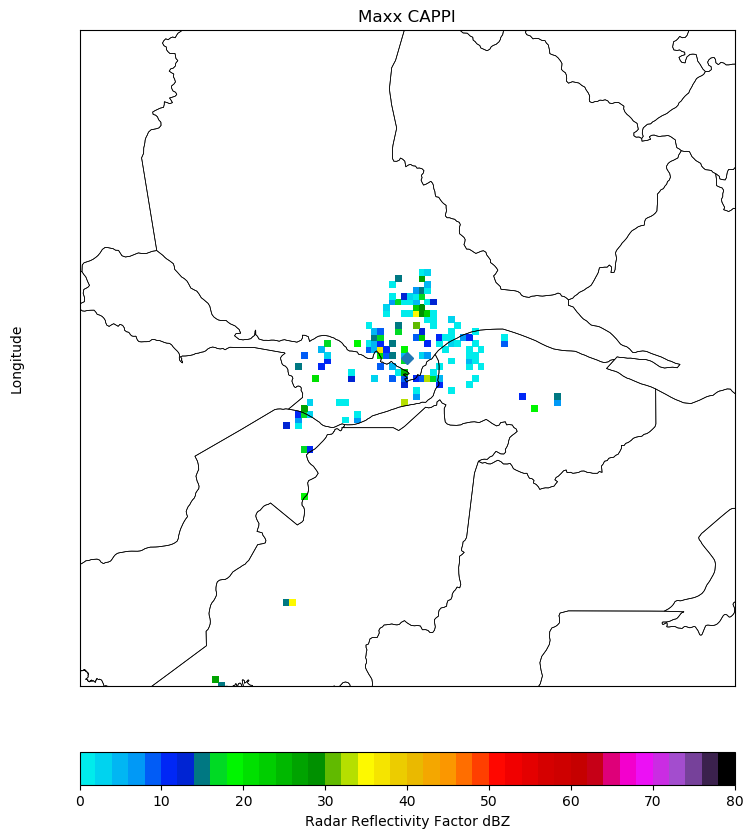

In [41]:
my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
zoom_scale = 1                        ## ZOOM SCALE


bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
        my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
label = 'Radar Reflectivity Factor ' + dbz_unit+ ''
title = 'Maxx CAPPI'

levs = np.linspace(0,80,41,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)
cmap = 'pyart_NWSRef'
ax = axes

m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

xi, yi = m(lon, lat)
xm, ym = m(my_coords[1],my_coords[0])

cs = m.pcolormesh(xi,yi,maxrange, cmap='Blues')
cs = m.pcolormesh(xi,yi,dados,norm=norm,cmap=cmap,ax=ax)
m.plot(xm,ym, marker='D',color='f')


# # # # Add Grid Lines
#m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
#m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
#m.drawmapboundary(fill_color='green')

m.readshapefile('./data/am_municipios/13MUE250GC_SIR', 'teste')

# # # # # Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(label)

# # # # # Add Title
plt.title(title)
plt.ylabel('Longitude', labelpad=40)
plt.xlabel('Latitude', labelpad=60)

plt.show()

In [ ]:
np.savetxt("dadosNAN.csv", dados, delimiter=",")